# Finetune a Langage Model with Fast.ai
Notebook based on:
- https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb
- https://github.com/fastai/course-nlp/blob/master/5-nn-imdb.ipynb

Video:
- https://www.youtube.com/watch?v=WjnwWeGjZcM (From 0:00 to 55:00)

#### Get latest Fast.ai version (without installing the Pytorch dependency)

In [1]:
!pip install --upgrade --no-deps fastai
!pip install --upgrade --no-deps fastcore

     |████████████████████████████████| 194kB 17.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 61kB 7.3MB/s 


#### Imports

In [2]:
from fastai.text.all import * # We need fastai version 2 for this
from pathlib import Path

#### Check GPU usage

In [3]:
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("WARNING: Not GPU detected")

Using GPU: Tesla T4


# Get data

In [7]:
CLOUD = True 

In [8]:
if CLOUD:
    # Download the data from internet
    # If you are using cloud platforms
    # like Google Colab or Kaggle kernels
    data_path = untar_data(URLs.IMDB)
else:
    # Point to the path where the data is
    # located at your local machine
    data_path = Path("../../Datasets/NLP/IMBd")
    
print("Dataset is loacted at:", data_path)

Dataset is loacted at: /root/.fastai/data/imdb


In [9]:
print("Train:", len(list( (data_path/"train").glob('**/*.txt') )), "reviews")
print("Test: ", len(list( (data_path/"test").glob('**/*.txt')  )), "reviews")
print("Unsup:", len(list( (data_path/"unsup").glob('**/*.txt') )), "reviews")

Train: 25000 reviews
Test:  25000 reviews
Unsup: 50000 reviews


# Dataset

In [10]:
files = get_text_files(data_path, folders = ['train', 'test', 'unsup'])
files

(#100000) [Path('/root/.fastai/data/imdb/train/neg/11850_3.txt'),Path('/root/.fastai/data/imdb/train/neg/11981_4.txt'),Path('/root/.fastai/data/imdb/train/neg/7924_1.txt'),Path('/root/.fastai/data/imdb/train/neg/6308_1.txt'),Path('/root/.fastai/data/imdb/train/neg/5460_4.txt'),Path('/root/.fastai/data/imdb/train/neg/284_2.txt'),Path('/root/.fastai/data/imdb/train/neg/11313_3.txt'),Path('/root/.fastai/data/imdb/train/neg/919_1.txt'),Path('/root/.fastai/data/imdb/train/neg/35_3.txt'),Path('/root/.fastai/data/imdb/train/neg/5452_4.txt')...]

In [11]:
txt = files[0].open().read()
txt[:75]

'"Rival reporters Pat Morgan (Ginger Rogers) and Ted Rand (Lyle Talbot) are '

## Dataloader

At every epoch:

1. **Shuffle** (sort randomly) our collection of texts.
2. **Concatenate** the individual texts together into a big stream. 
3. **Cut** this stream into a certain number of batches (which is our batch size).
   - For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens.
   
So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

- takes 5 mins for tokenization in Kaggle
- takes 1 mins for tokenization in local machine

In [12]:
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

imdb_dls_lm = DataBlock(
    blocks    = TextBlock.from_folder(data_path, is_lm=True),
    get_items = get_imdb,
    splitter  = RandomSplitter(0.1)
).dataloaders(data_path, path=data_path, bs=128, seq_len=80)

In [13]:
imdb_dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj ha ! xxmaj what a romp ! xxmaj although not as funny … ' shooting xxmaj fish ' is in the same tradition as ' saving xxmaj grace ' and ' lock , xxmaj stock and xxmaj two xxmaj smoking xxmaj barrels . ' xxmaj very silly and very entertaining xxmaj british humor . xxmaj my daughter and i enjoyed several belly laughs with this one and she even figured out the title without having to be told","xxmaj ha ! xxmaj what a romp ! xxmaj although not as funny … ' shooting xxmaj fish ' is in the same tradition as ' saving xxmaj grace ' and ' lock , xxmaj stock and xxmaj two xxmaj smoking xxmaj barrels . ' xxmaj very silly and very entertaining xxmaj british humor . xxmaj my daughter and i enjoyed several belly laughs with this one and she even figured out the title without having to be told ."
1,"arrives at the hotel and composes a lovely new song about crickets . xxmaj that 's when his wife and fellow world renown singer , xxmaj anna xxmaj albert , arrived . xxmaj the critics seemed to favor her over xxmaj victor , so there was friction between them ; xxmaj stan and xxmaj ollie were put to work plucking chickens , and as soon as xxmaj stan noticed a xxmaj st . xxmaj bernard with a barrel of rum","at the hotel and composes a lovely new song about crickets . xxmaj that 's when his wife and fellow world renown singer , xxmaj anna xxmaj albert , arrived . xxmaj the critics seemed to favor her over xxmaj victor , so there was friction between them ; xxmaj stan and xxmaj ollie were put to work plucking chickens , and as soon as xxmaj stan noticed a xxmaj st . xxmaj bernard with a barrel of rum around"


In [14]:
print(imdb_dls_lm.vocab[:100])

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that', '"', "'s", '-', 'was', '\n\n', 'as', 'with', 'for', 'movie', 'but', 'film', 'you', ')', 'on', "n't", '(', 'not', 'are', 'he', 'his', 'have', 'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', '!', 'there', 'or', 'just', 'her', 'do', 'about', 'has', 'out', "'", 'if', 'what', 'some', '?', 'good', 'when', 'more', 'very', 'she', 'up', 'would', 'no', '…', 'time', 'even', 'my', 'can', 'their', 'which', 'only', 'story', 'really', 'see', 'had', 'were', 'did', 'me', 'well', 'we', 'does', 'than', 'much', ':', 'could', 'bad', 'get']


In [15]:
len(imdb_dls_lm.vocab)

60008

# Create the Fastai learner (dataloader + model + loss)

In [16]:
learn = language_model_learner(
    dls       = imdb_dls_lm,
    arch      = AWD_LSTM,
    drop_mult = 0.3, 
    metrics   = [accuracy, Perplexity()],
    cbs       = [ShowGraphCallback]
).to_fp16()

### Text Generation BEFORE FINETUNNNG WITH IMDB (Just for fun :D)

In [17]:
TEXT        = "The"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

The George Lucas film Who Stole James Bond = = = The James Bond Story , also known as John Lucas Lucas Lucas ( Texas

The Innate Ability = = AUTOMOBILE Learning is an application of the Communication Devices ( GPS ) system , developed by National Institute of Technology Research ( PLIGHTS )

The Survival of Animals : The Complete Guide to the Animals , Animals , and Animals : The Life and Work of Charles Animals , Vol .

The F-- Programme = = as The Programme and the Mechanism of Public Policy ( English : Consciousness ) ( English : " The Programme " ) is a

The Walking Man = ( The Walking Man ) is a 1985 television documentary by Dirk Academy that depicts the life of a young young man ( Joseph Harris ) , who


## Fine-Tuning the Language Model with IMDB
- This takes 24:46 mins on GTX 1080ti 11GB
- This takes 27:48 mins on Tesla P100 16GB (Kaggle GPU)
- This takes ~22mins mins on Tesla T4 (Colab GPU)
- This takes >30mins mins on Tesla K80 (Colab GPU)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.004655,3.902814,0.300404,49.541683,20:53


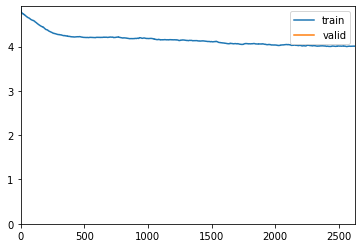

In [18]:
learn.fit_one_cycle(1, 2e-2)

### Saving and Loading Models
You can easily save the state of your model like so:

In [19]:
learn.save('IMDb_LM_1epoch_frozen')

Path('/root/.fastai/data/imdb/models/IMDb_LM_1epoch_frozen.pth')

In [20]:
learn.path

Path('/root/.fastai/data/imdb')

This will create a file in `learn.path/models/` named *IMDb_LM_1epoch_frozen.pth*. If you want to load your model in another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [21]:
learn = learn.load('IMDb_LM_1epoch_frozen')

Once the initial training has completed, we can continue fine-tuning the model after unfreezing:

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.767700,3.760485,0.316909,42.969246,22:05
1,3.710684,3.700438,0.323593,40.465015,22:12
2,3.620165,3.654345,0.328940,38.642204,22:33
3,3.558323,3.617564,0.332885,37.246731,22:31
4,3.483694,3.596979,0.335607,36.487850,22:47
5,3.416519,3.582272,0.337814,35.955139,22:48
6,3.360837,3.571783,0.339578,35.579967,22:34
7,3.298791,3.569939,0.340465,35.514431,22:46
8,3.244631,3.572859,0.340576,35.618275,22:30
9,3.207558,3.577470,0.340391,35.782890,22:34


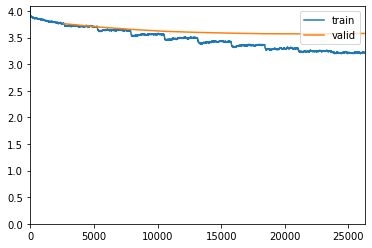

In [22]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [23]:
learn.save_encoder('finetuned_IMDb_LM')

> jargon: Encoder: The model not including the task-specific final layer(s). This term means much the same thing as _body_ when applied to vision CNNs, but "encoder" tends to be more used for NLP and generative models.

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### Text Generation AFTER FINETUNNNG WITH IMDB (Just for fun :D)
Before we move on to fine-tuning the classifier, let's quickly try something different: using our model to generate random reviews. Since it's trained to guess what the next word of the sentence is, we can use the model to write new reviews:

In [24]:
TEXT        = "The"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

The Jazz Singer is a wonderful movie , a must see for all opera lovers ! It is the story of the Jazz Singer Billie Holliday , who takes to singing , dancing ,

The Merchant of Venice is set in Rome during the Second World War , and is set in a Greek island . The city is a Greek island , so the

The Time Traveler 's Wife is a film that has the power to pull off great chemistry , especially with great direction from Peter Hyams , who also wrote the film . The film is

The original Bubble was in the ' 63 movie , " the Bubble " , and was the best movie ever made . It was the Israeli equivalent of The Godfather II , and

The famous French film " la Lollo De La Putain " ( directed by Maria Schrader ) tells the story of Crown Queen Mathieu ( belmondo ) , a French


In [25]:
TEXT        = "I liked this movie because"
N_WORDS     = 40
N_SENTENCES = 5

preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

print("\n\n".join(preds))

i liked this movie because of it 's unique style . The " official " review was written by Lee Van Cleef as Big Brother and i had n't heard of it from he 's Dads Army

i liked this movie because it showed a lot of men and women who were afraid of being married . It had a good story and a great cast that did n't want to change each other . It 's a must see

i liked this movie because it had a couple of good jokes , and i thought the plot was pretty good . 

 The previews made it look like a movie , but it just did n't work out . But it 's

i liked this movie because it was the first movie i have seen Richard Grieco to be in but i still liked it . i do n't know if this is a movie or not , but i think that it is a

i liked this movie because it was so smart , and had an interesting story . i see that people are n't still much into this movie , but if you like this kind of movies , you might like this one . i did


As you can see, we add some randomness (we pick a random word based on the probabilities returned by the model) so we don't get exactly the same review twice. Our model doesn't have any programmed knowledge of the structure of a sentence or grammar rules, yet it has clearly learned a lot about English sentences: we can see it capitalizes properly (*I* is just transformed to *i* because our rules require two characters or more to consider a word as capitalized, so it's normal to see it lowercased) and is using consistent tense. The general review makes sense at first glance, and it's only if you read carefully that you can notice something is a bit off. Not bad for a model trained in a couple of hours! 

But our end goal wasn't to train a model to generate reviews, but to classify them... so let's use this model to do just that.

# <center> END
<center> We have fintuned the Language Model with the IMDb dataset.
<center> The next step is using that model to train a classifier.